# IMPORTS & DOWNLOADS

In [3]:
# Data handling and preprocessing
import pandas as pd
import string
import numpy as np
import random

# NLTK and text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet  # Synonym replacement uses WordNet

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# Sklearn utilities
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight

# TensorFlow/Keras model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import re
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from keras_self_attention import SeqWeightedAttention
import torch


# Hugging Face Transformers (if needed)
from transformers import DistilBertTokenizer, DistilBertModel

# TensorFlow Hub (if needed)
import tensorflow_hub as hub

print('all done')


all done


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is alre

# LOADING THE FILES

In [4]:
#import pandas as pd

train_path = './train.txt'
test_path = './test_no_labels.txt'

train_df = pd.read_csv(train_path, sep='\t', names=['title', 'from', 'genre', 'director', 'plot'])
test_df = pd.read_csv(test_path, sep='\t', names=['title', 'from', 'director', 'plot'])

train_df.drop(['title', 'from', 'director'], axis=1, inplace=True)
test_df.drop(['title', 'from', 'director'], axis=1, inplace=True)

train_df.head(10)
#test_df.head()

,genre,plot
0,romance,Sekhar (Tarun) is a graduate from IIM and work...
1,horror,Kris Fowles (Katie Cassidy) goes to the Spring...
2,horror,Cynthia is traumatized by the death of her bab...
3,crime,"Four friends, Gangu (Jackie Shroff), Abdul (Na..."
4,drama,Crisis in a middle-class family when the son f...
5,action,Scarlett (Tatum O'Neal) is a hardened street k...
6,horror,"In 1630s New England, a man named William is b..."
7,romance,"Kushi (Radhika Pandit), Pratham (Tarun) and Sh..."
8,crime,"Nick Dunn, a used car salesman, can't close a ..."
9,comedy,During the Second World War Jimmy Bancroft (Ni...


# PREPROCESSING AND SPLITTING

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower() # lowercase the text
    text = text.translate(str.maketrans('', '', string.punctuation)) #remove punctuation and special chars
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)
    return text

#train_df['plot'] = train_df['plot'].apply(preprocess_text)

#print(train_df['plot'].head())


x = train_df['plot']
y = train_df['genre']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

genre_names = label_encoder.classes_
print("Class names:", genre_names)


# Split the dataset into training (70%), validation (15%), and test (15%)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=777)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=777)

print(x_train.head(10))
print(f"Training samples: {len(x_train)}, Test samples: {len(x_test)}")

Class names: ['action' 'animation' 'comedy' 'crime' 'drama' 'horror' 'romance' 'sci-fi'
 'western']
7005    Lyon Gaultier is a paratrooper in the French F...
3784    The film charts the stories of several people ...
2756    Loosely inspired by a novella by Cornell Woolr...
4183    Felix Milne (Meredith) is an overworked psycho...
6272    Devta is an Action flick, where Mithun plays t...
6471    Married doctors Niles (John Eldredge) and Caro...
51      Dracula, a Romanian prince, knight of the secr...
6640    Two special agents, Aziz and Lemi, are tasked ...
7106    A drug bust is about to go down and Chicago co...
6006    The story begins with a farm mother scolding J...
Name: plot, dtype: object
Training samples: 6432, Test samples: 805


# DATA AUGMENTATION

In [7]:
# Map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
# Get synonyms that match the part of speech of the word
def get_synonyms(word, pos):
    synonyms = set()
    
    for syn in wordnet.synsets(word, pos=pos):  # Only use synonyms with matching POS
        for lemma in syn.lemmas():
            # Exclude the word itself from the list of synonyms
            if lemma.name().lower() != word.lower():
                synonyms.add(lemma.name().replace('_', ' '))  # Convert underscores to spaces
    
    return list(synonyms)

def synonym_replacement(text, n):
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)  # Get POS tags for each word
    new_words = words.copy()
    
    # Filter for only alphanumeric words and their part-of-speech tags
    random_word_list = list(set([(word, get_wordnet_pos(tag)) for word, tag in pos_tags if word.isalnum() and get_wordnet_pos(tag)]))
    
    # Determine the number of words to replace based on the percentage `n`
    num_words_to_replace = max(1, int(len(random_word_list) * n))  # Ensure at least one word is replaced
    
    random.shuffle(random_word_list)  # Shuffle for randomness
    num_replaced = 0
    
    for random_word, pos in random_word_list:
        synonyms = get_synonyms(random_word, pos)  # Get synonyms matching the POS
        
        if synonyms:  # Replace only if there are synonyms available
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= num_words_to_replace:  # Stop when the desired number of replacements is reached
            break
    
    return ' '.join(new_words)

x_train = x_train.apply(preprocess_text)

# Copy the original training data
x_train_augmented = x_train.copy()

# Apply synonym replacement (data augmentation) to each plot in the copied data
x_train_augmented = x_train_augmented.apply(lambda plot: synonym_replacement(plot, n=0.5))  # Adjust `n` as needed

#x_train_augmented = x_train_augmented.apply(preprocess_text)

# Concatenate original and augmented plots
x_train_combined = pd.concat([x_train, x_train_augmented])

# Since we are duplicating the data, the labels must be duplicated as well
y_train_combined = np.concatenate([y_train, y_train])


##for printing purposes
#x_train = x_train.apply(preprocess_text)
#x_train_augmented = x_train_augmented.apply(preprocess_text)
x_train_combined = x_train_combined.apply(preprocess_text)
x_val = x_val.apply(preprocess_text)
x_test = x_test.apply(preprocess_text)

# Verify augmentation (optional: you can print some examples to see the effect)
print("Original plot example:\n", x_train.iloc[0])
print("Augmented plot example:\n", x_train_augmented.iloc[0])

print(f"Original training samples: {len(x_train)}")
print(f"Augmented training samples: {len(x_train_augmented)}")
print(f"Combined training samples: {len(x_train_combined)}")

# Proceed with the rest of the workflow, e.g., vectorization, model training, etc.

Original plot example:
 lyon gaultier paratrooper french foreign legion stationed djibouti north africa brother married american woman los angeles burned alive drug deal gone wrong suffers thirddegree burn dying shortly afterward lyon desert legion find withholding letter brother wife ultimately refuse let see dying brother steal jeep escape desert finding work tramp steamer headed u meanwhile legion commanding officer also travel state arriving french embassy told lyon desertion ranked low importance lapd order two legionnaire job lyon arrives new york city travel california brother family along way meet joshua man run fight money also learns cannot avenge brother murder failed identify killer dying tagging along joshua lyon meet cynthia organizes underground fight rich elite decides sponsor figuring would best way earn money family need lyon fight noholdsbarred bareknuckle fight finance trip reach la track brother widow reluctant accept financial aid even though obviously need angry 

# DistilBERT EMBEDDINGS LOADING

In [8]:
# Set up DistilBERT Model and Tokenizer
model_name = 'distilbert-base-uncased'  # Use DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)
model.eval()  # Set the model to evaluation mode


def get_transformer_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        sentence_embedding = last_hidden_states.mean(dim=1).squeeze().numpy()  # Average pooling
        embeddings.append(sentence_embedding)
    return np.array(embeddings)
# Generate embeddings
x_train_glove = get_transformer_embeddings(x_train_combined.tolist())
print('first one')
x_val_glove = get_transformer_embeddings(x_val.tolist())
print('second one')
x_test_glove = get_transformer_embeddings(x_test.tolist())
print('done getting glove embeddings')

x_train_glove = x_train_glove.reshape(x_train_glove.shape[0], 1, -1)  # Reshape to 3D
x_val_glove = x_val_glove.reshape(x_val_glove.shape[0], 1, -1)  # Reshape to 3D
x_test_glove = x_test_glove.reshape(x_test_glove.shape[0], 1, -1)  # Reshape to 3D

# Convert labels to numpy
y_train = np.array(y_train)
y_train_combined = np.array(y_train_combined)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_combined), y=y_train_combined)
class_weights = dict(enumerate(class_weights))

print('done converting labels and getting weights')

first one
second one
done getting glove embeddings
done converting labels and getting weights


# LSTM TRAINING AND RESULTS

done building and compiling the model
Epoch 1/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2491 - loss: 1.8662 - val_accuracy: 0.5585 - val_loss: 1.1860
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5037 - loss: 1.2026 - val_accuracy: 0.5945 - val_loss: 1.0803
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5542 - loss: 1.0910 - val_accuracy: 0.6343 - val_loss: 1.0059
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5766 - loss: 1.0446 - val_accuracy: 0.6045 - val_loss: 1.0510
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5896 - loss: 0.9976 - val_accuracy: 0.6306 - val_loss: 0.9946
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6058 - loss: 0.9634 - val_accuracy: 0.6393 - val_loss: 1.0143
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6098 - loss: 0.9567 - val_accuracy: 0.6281 - val_loss: 0.9990
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accu

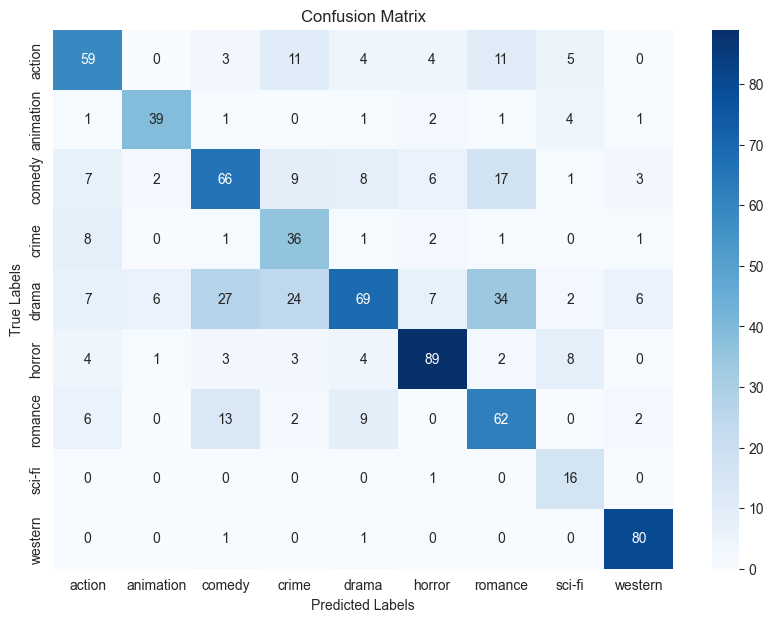

Classification Report:
              precision    recall  f1-score   support

      action       0.64      0.61      0.62        97
   animation       0.81      0.78      0.80        50
      comedy       0.57      0.55      0.56       119
       crime       0.42      0.72      0.53        50
       drama       0.71      0.38      0.49       182
      horror       0.80      0.78      0.79       114
     romance       0.48      0.66      0.56        94
      sci-fi       0.44      0.94      0.60        17
     western       0.86      0.98      0.91        82

    accuracy                           0.64       805
   macro avg       0.64      0.71      0.65       805
weighted avg       0.67      0.64      0.64       805



In [12]:
# Build the LSTM model
num_classes = len(np.unique(y_train))
lstm_model = Sequential()
lstm_model.add(Input(shape=(1,768)))  
lstm_model.add(LSTM(256, return_sequences=True))  
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(SeqWeightedAttention())
lstm_model.add(Dense(num_classes, activation='softmax'))



lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#lstm_model.compile(loss='sparse_categorical_crossentropy',optimizer=RMSprop(learning_rate=0.01), metrics=['accuracy'])

print('done building and compiling the model')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
# Train the LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lstm_model.fit(x_train_glove, y_train_combined, batch_size=32, epochs=100, validation_data=(x_val_glove, y_val), class_weight=class_weights, callbacks=[early_stopping])


# Evaluate the model
test_loss, test_accuracy = lstm_model.evaluate(x_test_glove, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


# Make predictions on the test set
y_pred_probs = lstm_model.predict(x_test_glove)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class predictions

genre_names = label_encoder.classes_
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=genre_names, yticklabels=genre_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=genre_names))

# BIDIRECTIONAL LSTM TRAINING AND RESULTS

done building and compiling the model
Epoch 1/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2895 - loss: 1.7770 - val_accuracy: 0.5721 - val_loss: 1.1816
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5369 - loss: 1.1305 - val_accuracy: 0.5846 - val_loss: 1.0912
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5670 - loss: 1.0664 - val_accuracy: 0.6182 - val_loss: 1.0668
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5832 - loss: 0.9993 - val_accuracy: 0.6331 - val_loss: 1.0393
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6068 - loss: 0.9593 - val_accuracy: 0.6343 - val_loss: 1.0021
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6298 - loss: 0.8951 - val_accuracy: 0.6194 - val_loss: 1.0167
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6322 - loss: 0.8906 - val_accuracy: 0.6343 - val_loss: 1.0492
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accu

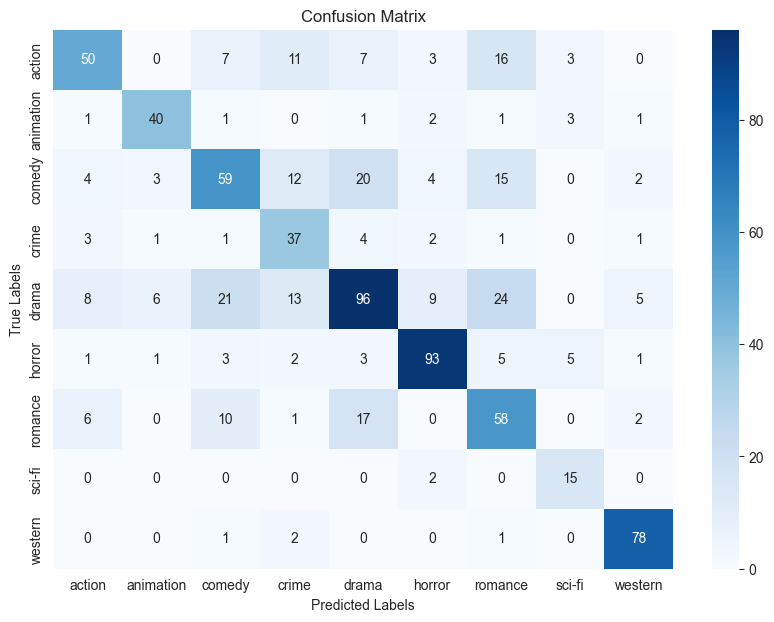

Classification Report:
              precision    recall  f1-score   support

      action       0.68      0.52      0.59        97
   animation       0.78      0.80      0.79        50
      comedy       0.57      0.50      0.53       119
       crime       0.47      0.74      0.58        50
       drama       0.65      0.53      0.58       182
      horror       0.81      0.82      0.81       114
     romance       0.48      0.62      0.54        94
      sci-fi       0.58      0.88      0.70        17
     western       0.87      0.95      0.91        82

    accuracy                           0.65       805
   macro avg       0.66      0.71      0.67       805
weighted avg       0.66      0.65      0.65       805



In [14]:
# Assuming num_classes and input data are already defined
num_classes = len(np.unique(y_train))

bilstm_model = Sequential()
bilstm_model.add(Input(shape=(1, 768)))  # Input with 300 features (e.g., from GloVe embeddings)
bilstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))  
bilstm_model.add(Dropout(0.3))
bilstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))  
bilstm_model.add(Dropout(0.3))
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))  
bilstm_model.add(Dropout(0.3))
bilstm_model.add(SeqWeightedAttention())
bilstm_model.add(Dense(num_classes, activation='softmax'))  # num_classes = number of classes

bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('done building and compiling the model')

# Train the LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
bilstm_model.fit(x_train_glove, y_train_combined, batch_size=32, epochs=100, validation_data=(x_val_glove, y_val), class_weight=class_weights, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = bilstm_model.evaluate(x_test_glove, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


# Make predictions on the test set
y_pred_probs = bilstm_model.predict(x_test_glove)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class predictions

genre_names = label_encoder.classes_
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=genre_names, yticklabels=genre_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=genre_names))

In [93]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=153)

x_train = x_train.apply(preprocess_text)
x_test = x_test.apply(preprocess_text)
# Copy the original training data
x_train_augmented = x_train.copy()

# Apply synonym replacement (data augmentation) to each plot in the copied data
x_train_augmented = x_train_augmented.apply(lambda plot: synonym_replacement(plot, n=0.8))  # Adjust `n` as needed

x_train_augmented = x_train_augmented.apply(preprocess_text)

# Concatenate original and augmented plots
x_train_combined = pd.concat([x_train, x_train_augmented])

# Since we are duplicating the data, the labels must be duplicated as well
y_train_combined = np.concatenate([y_train, y_train])

vectorizer = TfidfVectorizer()
x_train_vec = vectorizer.fit_transform(x_train_combined)
x_test_vec = vectorizer.transform(x_test)
smote = SMOTE(random_state=153)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_vec, y_train_combined)
# Define parameter grid for alpha
param_grid = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}

# Use GridSearchCV to tune the alpha hyperparameter
grid_search = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(x_train_resampled, y_train_resampled)

y_testpred = grid_search.predict(x_test_vec.toarray())
print("Gauss accuracy on test set: ", round(metrics.accuracy_score(y_test, y_testpred),2))

print(metrics.classification_report(y_test, y_testpred, target_names=genre_names))

Gauss accuracy on test set:  0.65
              precision    recall  f1-score   support

           0       0.69      0.53      0.60       222
           1       0.82      0.80      0.81        97
           2       0.64      0.52      0.57       244
           3       0.49      0.55      0.52       108
           4       0.63      0.52      0.57       308
           5       0.68      0.87      0.76       231
           6       0.52      0.62      0.57       187
           7       0.56      0.64      0.60        45
           8       0.81      0.96      0.88       167

    accuracy                           0.65      1609
   macro avg       0.65      0.67      0.65      1609
weighted avg       0.65      0.65      0.64      1609

